In [1]:
import os
import math
import scipy
import datetime
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
from scipy.stats import randint
from scipy.stats import loguniform
from IPython.display import display


from sklearn.cluster import KMeans
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings('ignore')

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [2]:
!pip install openpyxl

In [3]:
!wget https://archive.ics.uci.edu/static/public/352/online+retail.zip

--2024-07-20 19:44:50--  https://archive.ics.uci.edu/static/public/352/online+retail.zip
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified
Saving to: ‘online+retail.zip.1’

online+retail.zip.1     [      <=>           ]  22.62M  92.4KB/s    in 3m 35s  

2024-07-20 19:48:25 (108 KB/s) - ‘online+retail.zip.1’ saved [23715478]



In [4]:
!unzip ./online+retail.zip -d data

Archive:  ./online+retail.zip
replace data/Online Retail.xlsx? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
 extracting: data/Online Retail.xlsx  


## **Data**

**Name**: **Customer Segmentation Dataset**\
**Source**: UC Irvine machine learning repository\
**Link**: https://archive.ics.uci.edu/dataset/352/online+retail


This is a transnational data set which contains all the transactions occurring between 01/12/2010 and 09/12/2011 for a UK-based and registered non-store online retail.The company mainly sells unique all-occasion gifts. Many customers of the company are wholesalers.

**Objective**:¶
<br/>

- Understand the Dataset & cleanup (if required).
- Build clustering model to segment the customer based similarity.
- Also fine-tune the hyperparameters & compare the evaluation metrics of vaious classification algorithms.


In [5]:
df = pd.read_excel('./data/Online Retail.xlsx')

original_df = df.copy(deep=True)
display(df.head())

print('\n\033[1mInference:\033[0m The Datset consists of {} features & {} samples.'.format(df.shape[1], df.shape[0]))

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom



Inference: The Datset consists of 8 features & 541909 samples.


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


According to the output of the dataset that we got, we can conclude the following:


**InvoiceNo**: A unique identifier for each transaction. It signifies the invoice number associated with each purchase. For example, "536365" is the invoice number for the transactions shown.

**StockCode**: A unique identifier for each item (product). For instance, "85123A" corresponds to the "WHITE HANGING HEART T-LIGHT HOLDER."

**Description**: A textual description of the item. Examples include "WHITE HANGING HEART T-LIGHT HOLDER" and "WHITE METAL LANTERN."

**Quantity**: The number of units of the item purchased. In the sample, all quantities are 6 or 8.

**InvoiceDate**: The date and time when the transaction occurred. For example, "2010-12-01 08:26:00" indicates that the transaction took place on December 1, 2010, at 08:26 AM.

**UnitPrice**: The price per unit of the item. For example, the "WHITE HANGING HEART T-LIGHT HOLDER" costs 2.55 (in the currency relevant to the dataset, likely GBP).

**CustomerID**: A unique identifier for the customer who made the purchase. For instance, "17850.0" is the customer ID in the shown rows.

**Country**: The country where the customer resides. In the example provided, all customers are from the "United Kingdom."

## **Goals of the Dataset**:

We can use this dataset in the following cases. But we here will only use for **Customer Segmentation**

**Sales Analysis**: The dataset can be used to analyze sales patterns, such as identifying best-selling products, peak sales times, and customer purchasing behavior.

**Customer Segmentation**: By examining customer IDs and their purchasing patterns, businesses can segment customers based on buying behavior and tailor marketing strategies accordingly.

**Inventory Management**: Understanding which products are popular and in what quantities can help in managing stock levels more efficiently.

**Revenue Analysis**: Calculating total revenue, average order value, and other financial metrics to assess business performance.

**Market Trends**: Identifying trends over time, such as seasonal variations in product demand.

**Customer Retention**: Analyzing repeat purchases by the same customers to develop loyalty programs and improve customer retention strategies.

## Data Cleaning

In [7]:
round(100*(df.isnull().sum())/len(df) )

InvoiceNo       0.0
StockCode       0.0
Description     0.0
Quantity        0.0
InvoiceDate     0.0
UnitPrice       0.0
CustomerID     25.0
Country         0.0
dtype: float64

In [8]:
df = df.dropna()
df.shape

(406829, 8)

In [9]:
df['CustomerID'] = df['CustomerID'].astype(str)

## Calculating the Missing Values % contribution in DF


In [10]:
df["InvoiceDate"] = df["InvoiceDate"].dt.date
df["TotalSum"] = df["Quantity"] * df["UnitPrice"]
snapshot_date = max(df.InvoiceDate) + datetime.timedelta(days=1)
customers = df.groupby(['CustomerID']).agg({'InvoiceDate': lambda x: (snapshot_date - x.max()).days,
                                            'InvoiceNo': 'count','TotalSum': 'sum'})
customers.rename(columns = {'InvoiceDate': 'Recency','InvoiceNo': 'Frequency',
                            'TotalSum': 'Amount'}, inplace=True)
#customers = customers[customers.MonetaryValue>0]
display(customers.head())

,Recency,Frequency,Amount
CustomerID,,,
12346.0,326,2,0.00
12347.0,3,182,4310.00
12348.0,76,31,1797.24
12349.0,19,73,1757.55
12350.0,311,17,334.40


### Data Types of Customers DF

In [11]:
customers.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4372 entries, 12346.0 to 18287.0
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Recency    4372 non-null   int64  
 1   Frequency  4372 non-null   int64  
 2   Amount     4372 non-null   float64
dtypes: float64(1), int64(2)
memory usage: 136.6+ KB


### Checking the stats of all the columns

In [12]:
display(customers.describe())

,Recency,Frequency,Amount
count,4372.000000,4372.000000,4372.000000
mean,92.581199,93.053294,1898.459701
std,100.772139,232.471608,8219.345141
min,1.000000,1.000000,-4287.630000
25%,17.000000,17.000000,293.362500
50%,51.000000,42.000000,648.075000
75%,144.000000,102.000000,1611.725000
max,374.000000,7983.000000,279489.020000


## Exploratory Data Analysis (EDA)


In [13]:
customers.head()

,Recency,Frequency,Amount
CustomerID,,,
12346.0,326,2,0.00
12347.0,3,182,4310.00
12348.0,76,31,1797.24
12349.0,19,73,1757.55
12350.0,311,17,334.40


In [14]:
import plotly.express as px


# Create a DataFrame containing the selected attributes
attributes = ['Amount', 'Frequency', 'Recency']
data = customers[attributes]

# Create a box plot with Plotly
fig = px.box(data, y=attributes, labels={'variable': 'Attributes', 'value': 'Range'},
             title="Outliers Variable Distribution")
fig.update_layout(
    xaxis=dict(title="Attributes"),
    yaxis=dict(title="Range"),
    showlegend=False,
    boxmode='group',  # Display box plots side by side
    width=800, height=600
)
fig.show()

In [15]:
# Removing (statistical) outliers for Amount
Q1 = customers.Amount.quantile(0.05)
Q3 = customers.Amount.quantile(0.95)
IQR = Q3 - Q1
customers = customers[(customers.Amount >= Q1 - 1.5*IQR) & (customers.Amount <= Q3 + 1.5*IQR)]



# Removing (statistical) outliers for Recency
Q1 = customers.Recency.quantile(0.05)
Q3 = customers.Recency.quantile(0.95)
IQR = Q3 - Q1
customers = customers[(customers.Recency >= Q1 - 1.5*IQR) & (customers.Recency <= Q3 + 1.5*IQR)]

# Removing (statistical) outliers for Frequency
Q1 = customers.Frequency.quantile(0.05)
Q3 = customers.Frequency.quantile(0.95)
IQR = Q3 - Q1
customers = customers[(customers.Frequency >= Q1 - 1.5*IQR) & (customers.Frequency <= Q3 + 1.5*IQR)]

**Purpose of Outlier Removal**:¶\
Outliers can distort statistical analyses and models by introducing noise and skewing results.

Removing outliers helps in obtaining a more representative view of the dataset and its underlying patterns.

It can improve the accuracy and reliability of insights derived from the data.

However, removing outliers should be done carefully, and the choice of the 1.5*IQR range is a common heuristic.

It's essential to consider the context and business goals.

In summary, the provided code removes statistical outliers from the "Amount," "Recency," and "Frequency" attributes to ensure that subsequent analyses and modeling are based on a cleaner and more representative dataset.

In [16]:
attributes = ['Amount', 'Frequency', 'Recency']

fig = px.box(customers, y=attributes, title="Outliers Variable Distribution",
             labels={'variable': 'Attributes', 'value': 'Range'},
             boxmode='group', points='outliers')

fig.update_layout(
    xaxis=dict(title="Attributes", title_font=dict(size=14)),
    yaxis=dict(title="Range", title_font=dict(size=14)),
    showlegend=False,
    width=800,
    height=600
)

fig.show()

**Rescaling the Attributes**\
It is extremely important to rescale the variables so that they have a comparable scale.\
There are two common ways of rescaling:
  - 1-Min-Max scaling
  - 2-Standardisation (mean-0, sigma-1)

Here, we will use Standardisation Scaling.

In [17]:
# Rescaling the attributes

merged_rfm = customers[['Amount', 'Frequency', 'Recency']]

# Instantiate
scaler = StandardScaler()

# fit_transform
rfm_df_scaled = scaler.fit_transform(merged_rfm)
rfm_df_scaled.shape

(4293, 3)

In [18]:
rfm_df_scaled = pd.DataFrame(rfm_df_scaled)
rfm_df_scaled.columns = ['Amount', 'Frequency', 'Recency']
rfm_df_scaled.head()

,Amount,Frequency,Recency
0,-0.723738,-0.752888,2.296184
1,1.731617,1.042467,-0.901811
2,0.300128,-0.463636,-0.179044
3,0.277517,-0.044720,-0.743397
4,-0.533235,-0.603275,2.147671


## **Models Building**
**K-Means Clustering**\
K-means clustering is one of the simplest and popular unsupervised machine learning algorithms.
The algorithm works as follows:

- 1-First we initialize k points, called means, randomly.

- 2-We categorize each item to its closest mean and we update the mean’s coordinates, which are the averages of the items categorized in that mean so far.

- 3-We repeat the process for a given number of iterations and at the end, we have our clusters.italicized text

In [19]:
# k-means with some arbitrary k

kmeans = KMeans(n_clusters=4, max_iter=50)
kmeans.fit(rfm_df_scaled)

KMeans(max_iter=50, n_clusters=4)

In [20]:
kmeans.labels_

array([3, 1, 0, ..., 3, 0, 0], dtype=int32)

### Finding the Optimal Number of Clusters
Elbow Curve to get the right number of Clusters\
A fundamental step for any unsupervised algorithm is to determine the optimal number of clusters into which the data may be clustered.

The Elbow Method is one of the most popular methods to determine this optimal value of k.


In [21]:
ssd = []
range_n_clusters = [2, 3, 4, 5, 6, 7, 8]

for num_clusters in range_n_clusters:
    kmeans = KMeans(n_clusters=num_clusters, max_iter=50)
    kmeans.fit(rfm_df_scaled)

    ssd.append(kmeans.inertia_)
    print("For n_clusters={0}, the Elbow score is {1}".format(num_clusters, kmeans.inertia_))

fig = px.line(x=range_n_clusters, y=ssd,
              title="Elbow Curve for K-Means Clustering",
              labels={'x': 'Number of Clusters', 'y': 'Sum of Squared Distances (SSD)'},markers=True)

fig.update_layout(
    xaxis=dict(title_font=dict(size=14)),
    yaxis=dict(title_font=dict(size=14)),
    showlegend=False,
    width=800,
    height=600
)

fig.show()

For n_clusters=2, the Elbow score is 7661.565095492545
For n_clusters=3, the Elbow score is 4433.972645231035
For n_clusters=4, the Elbow score is 3361.207521193669
For n_clusters=5, the Elbow score is 2803.2061015161335
For n_clusters=6, the Elbow score is 2392.5075281097706
For n_clusters=7, the Elbow score is 2039.6288516458824
For n_clusters=8, the Elbow score is 1826.787039765472


**Silhouette Analysis**

$$silhouette\_score=p−q/max(p,q)$$

1. `p` is the mean distance to the points in the nearest cluster that the data point is not a part of.

2. `q` is the mean intra-cluster distance to all the points in its own cluster.

3. The value of the silhouette score range lies between -1 to 1.

A score closer to 1 indicates that the data point is very similar to other data points in the cluster,

A score closer to -1 indicates that the data point is not similar to the data points in its cluster.

Silhouette analysis helps you assess the quality of clustering and find the number of clusters that best fits your data. Let's break down the code and understand its purpose:

**Purpose of Silhouette Analysis:**

Silhouette analysis helps you assess the quality of clustering for different numbers of clusters.

The silhouette score ranges from -1 to 1, with higher values indicating better cluster separation and cohesion.

By examining silhouette scores for various cluster numbers, you can determine the optimal number of clusters that best fit your data.

In summary, this code performs silhouette analysis for a range of cluster numbers using K-Means clustering on the standardized RFM data. It helps you select the number of clusters that provides the best clustering quality for your data.

In [22]:
from sklearn.metrics import silhouette_score

# Silhouette analysis
range_n_clusters = [2, 3, 4, 5, 6, 7, 8]

for num_clusters in range_n_clusters:

    # intialise kmeans
    kmeans = KMeans(n_clusters=num_clusters, max_iter=50)
    kmeans.fit(rfm_df_scaled)

    cluster_labels = kmeans.labels_

    # silhouette score
    silhouette_avg = silhouette_score(rfm_df_scaled, cluster_labels)
    print("For n_clusters={0}, the silhouette score is {1:.4f}".format(num_clusters, silhouette_avg))

For n_clusters=2, the silhouette score is 0.5413
For n_clusters=3, the silhouette score is 0.5084
For n_clusters=4, the silhouette score is 0.4777
For n_clusters=5, the silhouette score is 0.4639
For n_clusters=6, the silhouette score is 0.4177
For n_clusters=7, the silhouette score is 0.4177
For n_clusters=8, the silhouette score is 0.4092


For n_clusters=2, the silhouette score is 0.5413
For n_clusters=3, the silhouette score is 0.5084
For n_clusters=4, the silhouette score is 0.4797
For n_clusters=5, the silhouette score is 0.4662
For n_clusters=6, the silhouette score is 0.4169
For n_clusters=7, the silhouette score is 0.4175
For n_clusters=8, the silhouette score is 0.4089


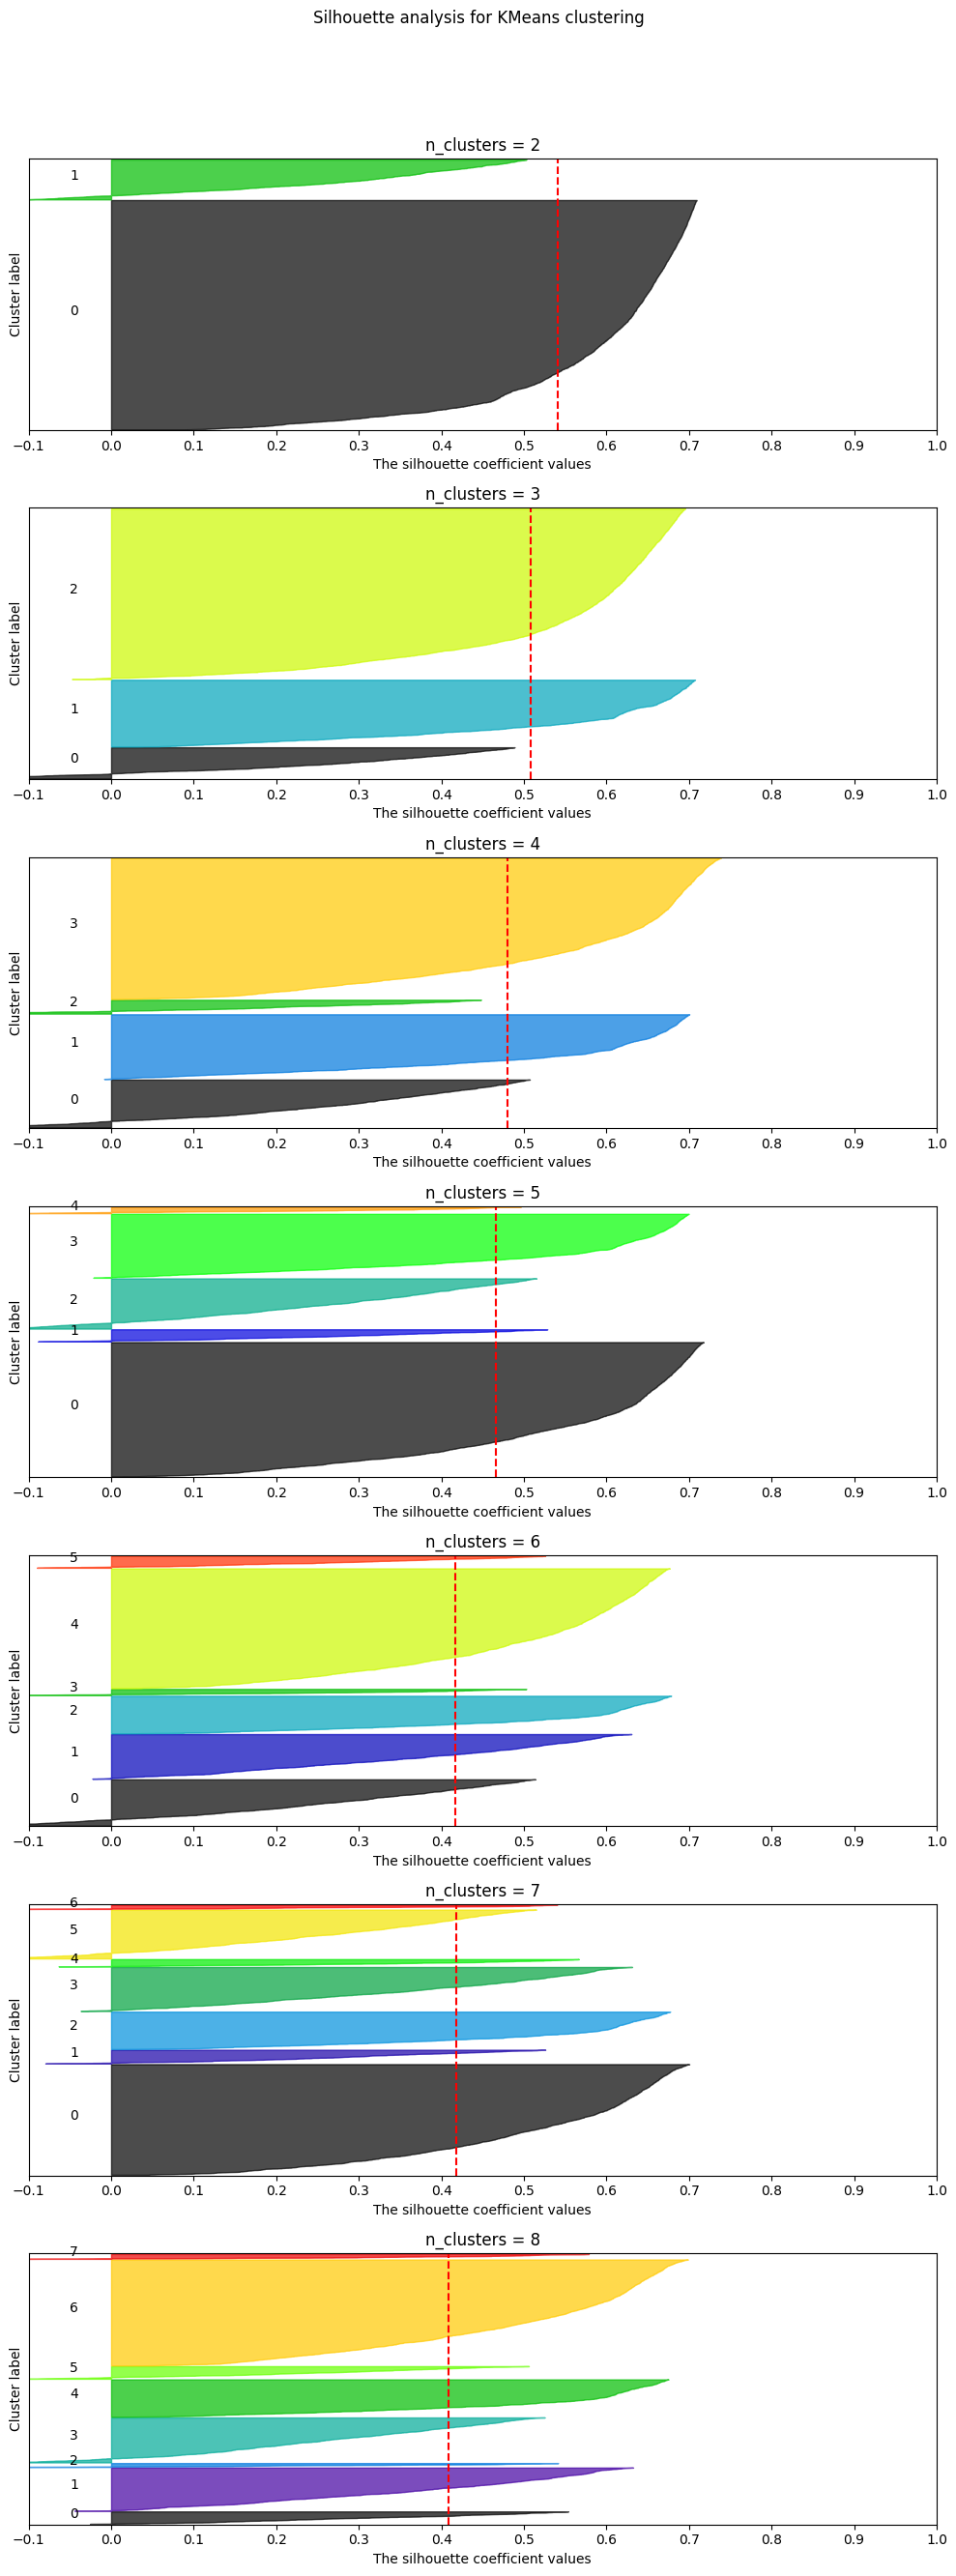

In [23]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score

# Assuming rfm_df_scaled is your scaled data

# Silhouette analysis
range_n_clusters = [2, 3, 4, 5, 6, 7, 8]

# Create a figure with subplots
fig, axes = plt.subplots(len(range_n_clusters), 1, figsize=(10, len(range_n_clusters) * 4))
fig.suptitle("Silhouette analysis for KMeans clustering")

for ax, n_clusters in zip(axes, range_n_clusters):
    # Initialize KMeans
    kmeans = KMeans(n_clusters=n_clusters, max_iter=50, random_state=42)
    cluster_labels = kmeans.fit_predict(rfm_df_scaled)

    # Compute the silhouette score
    silhouette_avg = silhouette_score(rfm_df_scaled, cluster_labels)
    print(f"For n_clusters={n_clusters}, the silhouette score is {silhouette_avg:.4f}")

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(rfm_df_scaled, cluster_labels)

    ax.set_xlim([-0.1, 1])
    ax.set_ylim([0, len(rfm_df_scaled) + (n_clusters + 1) * 10])

    y_lower = 10
    for i in range(n_clusters):
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]
        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = plt.cm.nipy_spectral(float(i) / n_clusters)
        ax.fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_silhouette_values, facecolor=color, edgecolor=color, alpha=0.7)

        ax.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
        y_lower = y_upper + 10

    ax.set_title(f"n_clusters = {n_clusters}")
    ax.set_xlabel("The silhouette coefficient values")
    ax.set_ylabel("Cluster label")

    ax.axvline(x=silhouette_avg, color="red", linestyle="--")
    ax.set_yticks([])
    ax.set_xticks([i / 10.0 for i in range(-1, 11)])

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

**k=2, k=6, k=7, k=8:**

These plots likely show many silhouette coefficient values close to 0, indicating data points on cluster borders. They might not be the best choices.

**k=3 and k=4:**

These plots show a better distribution of silhouette coefficients, with more points having values closer to 1 (well-separated clusters).\
**k=4** might be slightly better than **k=3** based on the provided silhouette plots, but it depends on the specific details.

In the context of clustering, when you have multiple options for the number of clusters, you typically aim to choose the number of clusters that maximizes the silhouette score. In your provided output, you have calculated silhouette scores for different numbers of clusters, and you want to select the best number.\
Here's a simplified explanation for why "3" was chosen from the provided silhouette scores:\
<br/>

**Silhouette Score Meaning**:\
 The silhouette score measures how similar each data point in a cluster is to the data points in the same cluster compared to other clusters. The score ranges from -1 to 1:**

A higher score indicates better cluster separation and cohesion.

A score close to 0 suggests overlapping or ambiguous clusters.

A negative score means that data points might be assigned to the wrong clusters.

Choosing the Best Number of Clusters: To determine the best number of clusters, you typically look for the number that gives the highest silhouette score.

**Silhouette scores**:

**For n_clusters=2, the silhouette score is 0.5413.\
For n_clusters=3, the silhouette score is 0.5084.\
For n_clusters=4, the silhouette score is 0.4777.\
For n_clusters=5, the silhouette score is 0.4662.\
For n_clusters=6, the silhouette score is 0.4170.\
For n_clusters=7, the silhouette score is 0.4149.\
For n_clusters=8, the silhouette score is 0.4027.**

==> You chose "3" as the number of clusters because it has the second-highest silhouette score (0.5085),

==> and it indicates reasonably good cluster separation and cohesion.

==> While the silhouette score for 2 clusters is slightly higher, the difference is not substantial,

==> and having 3 clusters may provide a more detailed and meaningful separation of your data.

==> Keep in mind that the choice of the number of clusters may also depend on the specific problem and the insights you want to gain from the clustering analysis.

It's often a balance between finding a simple model (few clusters) and capturing meaningful patterns (more clusters).
<br/>

**Silhouette Analysis Vs Elbow**:

Imagine you have a group of friends, and you want to split them into different teams for a game. Silhouette analysis is like a way to see how well your friends fit into their teams.

**Purpose**:

Silhouette analysis helps you figure out how good the teams are. It looks at whether your friends are happy with their teams or if they should switch to another team to be even happier.**

**Measurement**:

It gives each friend a score from -1 to 1. If the score is close to 1, it means they're really happy in their team. If it's close to 0, it means they might be confused because their team is similar to other teams. And if it's negative, it means they're not in the right team.

**Goal**:

You want to find the number of teams that makes everyone as happy as possible, with the highest average (average means adding up all the scores and dividing by the number of friends).

**Elbow Method**:

Now, let's say you want to know how many teams to make for a different game with your friends. The elbow method helps you decide how many teams to create.

**Purpose**:

The elbow method helps you find the right number of teams for your game.

You don't want too few teams, and you don't want too many. You want to strike a balance.

**Measurement**:

Imagine you have a graph that shows how good the teams are. On the graph, you have the number of teams on one side and how well they're organized on the other side. The graph looks like a bent arm with an elbow.

**Goal**:

You want to find the point where the graph starts to bend like an elbow. That point tells you the right number of teams. If you have too few or too many teams, it won't be a clear bend, and that's not what you want.

**Summary**:

Silhouette analysis checks how happy your friends are in their teams using scores from -1 to 1.

You want the highest average score for the best number of teams.

The elbow method looks at a graph and finds the point where it bends like an elbow. That point tells you how many teams to create for your game.

Both methods help you figure out the best way to group things, whether it's friends or data, by considering how happy or organized they are.3

When choosing the number of clusters for a clustering problem, it's important to consider both the silhouette score and the elbow method results, as they provide complementary insights. Here's how to make the decision based on your provided results:

**Silhouette Score**:
The silhouette score measures the quality of the clusters.

Higher silhouette scores indicate better separation and cohesion of clusters.

In your case, the highest silhouette score is for 2 clusters (0.5416), but the second-highest score is for 3 clusters (0.5085), which is still quite good.

**Elbow Method**:
The elbow method looks at the reduction in error (WCSS) as you increase the number of clusters.

The point where adding more clusters doesn't significantly reduce the error is often considered the "elbow" and a reasonable choice for the number of clusters.

**Decision**:
Silhouette Score: The silhouette score suggests that 2 clusters or 3 clusters are both reasonable choices. Both options have good silhouette scores, with 2 clusters having a slightly higher score.

**Elbow Method**: The elbow method suggests that the "elbow" point occurs at 3 clusters. This is where the reduction in error starts to slow down significantly.

**Conclusion**:
Based on the silhouette score, you could choose either 2 or 3 clusters, and both are valid choices.

However, considering the results from both methods and the fact that the elbow method indicates a clear point at 3 clusters, it may be a good idea to choose 3 clusters as the number of clusters for your clustering analysis.

Ultimately, the choice between 2 and 3 clusters depends on your specific problem, the insights you want to gain, and your preference for having a more detailed or simplified grouping of your data.

You can start with 3 clusters and, if needed, explore the results further to see if they make sense for your particular application.

In [24]:
# Final model with k=3
kmeans = KMeans(n_clusters=3, max_iter=50)
kmeans.fit(rfm_df_scaled)
print(kmeans.labels_)


[1 0 2 ... 1 2 2]


In [25]:
# assign the label
merged_rfm['Cluster_Id'] = kmeans.labels_
merged_rfm.head()

,Amount,Frequency,Recency,Cluster_Id
CustomerID,,,,
12346.0,0.00,2,326,1
12347.0,4310.00,182,3,0
12348.0,1797.24,31,76,2
12349.0,1757.55,73,19,2
12350.0,334.40,17,311,1


In [26]:
fig = px.box(merged_rfm, x='Cluster_Id', y='Amount',
             title="Cluster Id vs Amount Box Plot",
             labels={'Cluster_Id': 'Cluster ID', 'Amount': 'Amount'},
             color='Cluster_Id')

fig.update_layout(
    xaxis=dict(title="Cluster ID", title_font=dict(size=14)),
    yaxis=dict(title="Amount", title_font=dict(size=14)),
    showlegend=False,
    width=800,
    height=600
)

fig.show()

In [27]:
fig = px.scatter(merged_rfm, x='Cluster_Id', y='Amount', color='Frequency',
                 title='Cluster ID vs Amount (Color Encoded by Frequency)',
                 labels={'Cluster_Id': 'Cluster ID', 'Amount': 'Amount', 'Frequency': 'Frequency'})

fig.update_layout(
    xaxis=dict(title="Cluster ID", title_font=dict(size=14)),
    yaxis=dict(title="Amount", title_font=dict(size=14)),
    showlegend=True,
    width=800,
    height=600
)

fig.show()

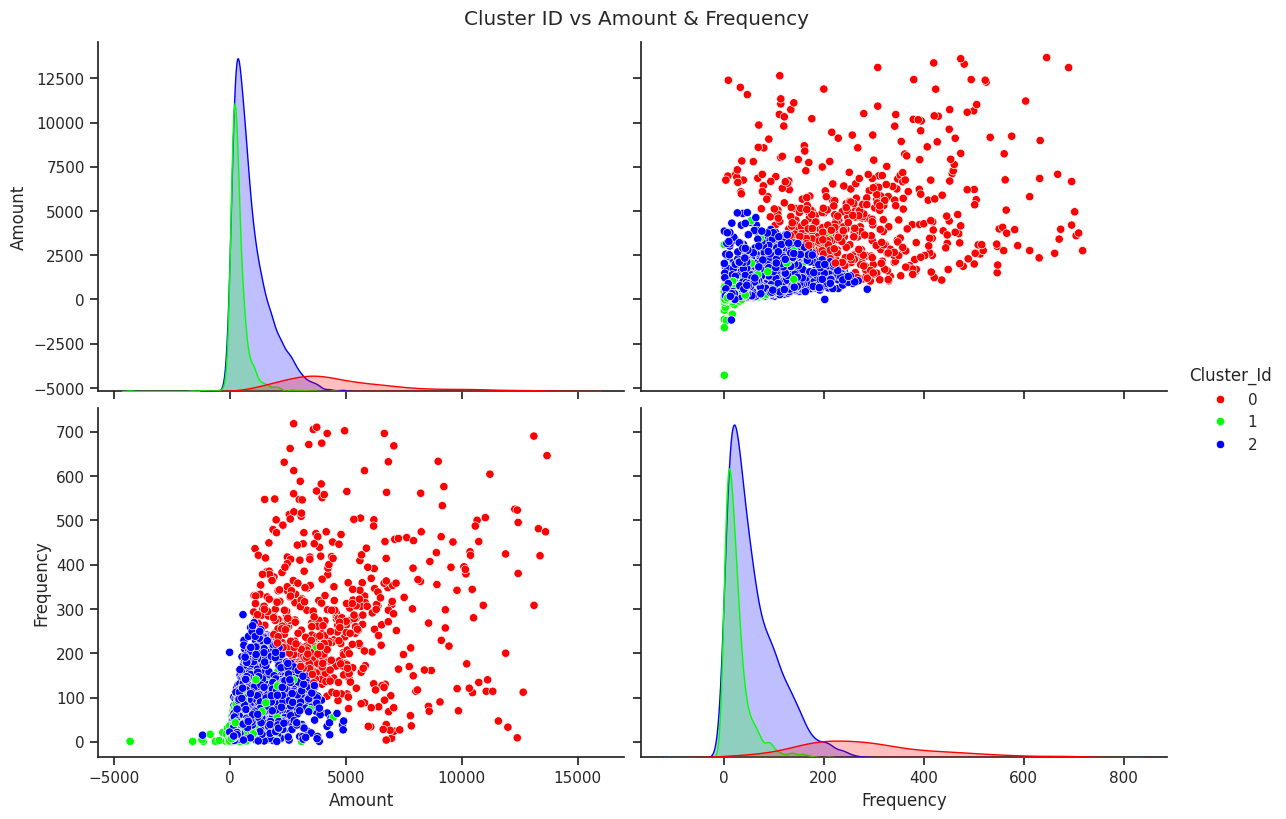

In [28]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create a custom color palette with Red, Green, and Blue
custom_palette = sns.color_palette(["#FF0000", "#00FF00", "#0000FF"])

# Create a scatter plot matrix with separate plots for each cluster, custom palette, and a larger size
sns.set(style="ticks")
sns.pairplot(merged_rfm, hue='Cluster_Id', vars=['Amount', 'Frequency'], palette=custom_palette, height=4, aspect=1.5)
plt.suptitle('Cluster ID vs Amount & Frequency', y=1.02)
plt.show()

In [29]:
fig = px.box(merged_rfm, x='Cluster_Id', y='Frequency',
             title="Cluster Id vs Frequency Box Plot",
             labels={'Cluster_Id': 'Cluster ID', 'Frequency': 'Frequency'})

fig.update_layout(
    xaxis=dict(title="Cluster ID", title_font=dict(size=14)),
    yaxis=dict(title="Frequency", title_font=dict(size=14)),
    showlegend=False,
    width=800,
    height=600
)

fig.show()

### Box plot to visualize Cluster Id vs Recency¶

In [30]:
fig = px.box(merged_rfm, x='Cluster_Id', y='Recency',
             title="Cluster Id vs Recency Box Plot",
             labels={'Cluster_Id': 'Cluster ID', 'Recency': 'Recency'})

fig.update_layout(
    xaxis=dict(title="Cluster ID", title_font=dict(size=14)),
    yaxis=dict(title="Recency", title_font=dict(size=14)),
    showlegend=False,
    width=800,
    height=600
)

fig.show()

In [31]:
# Selecting the two features for clustering
data_for_clustering = merged_rfm[['Amount', 'Frequency']]

# Specify the number of clusters (e.g., 3)
n_clusters = 3

# Apply K-Means clustering
kmeans = KMeans(n_clusters=n_clusters)
merged_rfm['Cluster_2D'] = kmeans.fit_predict(data_for_clustering)

# Create a scatter plot with Plotly
fig = px.scatter(merged_rfm, x='Amount', y='Frequency', color='Cluster_2D',
                 title='Clustering by Amount and Frequency',
                 labels={'Amount': 'Amount', 'Frequency': 'Frequency', 'Cluster_2D': 'Cluster'})

fig.update_layout(
    xaxis=dict(title="Amount", title_font=dict(size=14)),
    yaxis=dict(title="Frequency", title_font=dict(size=14)),
    width=800,
    height=600
)

fig.show()

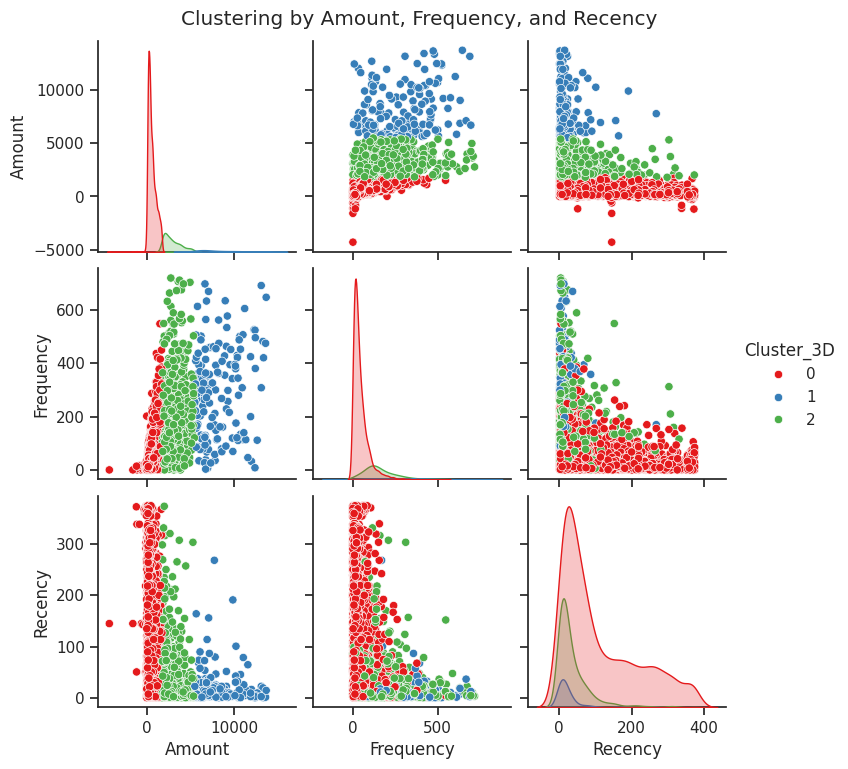

In [32]:
# Selecting the three features for clustering
data_for_clustering = merged_rfm[['Amount', 'Frequency', 'Recency']]

# Apply K-Means clustering
kmeans = KMeans(n_clusters=n_clusters)
merged_rfm['Cluster_3D'] = kmeans.fit_predict(data_for_clustering)

# Visualize the clusters (scatter plot matrix)
sns.set(style="ticks")
sns.pairplot(merged_rfm, hue='Cluster_3D', vars=['Amount', 'Frequency', 'Recency'], palette='Set1')
plt.suptitle('Clustering by Amount, Frequency, and Recency', y=1.02)
plt.show()

In [33]:
import plotly.express as px

# Apply K-Means clustering
kmeans = KMeans(n_clusters=n_clusters)
merged_rfm['Cluster_3D'] = kmeans.fit_predict(data_for_clustering)

# Create a 3D scatter plot matrix with Plotly
fig = px.scatter_3d(merged_rfm, x='Amount', y='Frequency', z='Recency', color='Cluster_3D',
                     labels={'Amount': 'Amount', 'Frequency': 'Frequency', 'Recency': 'Recency', 'Cluster_3D': 'Cluster'})

fig.update_layout(
    scene=dict(
        xaxis_title='Amount',
        yaxis_title='Frequency',
        zaxis_title='Recency',
    ),
    title='Clustering by Amount, Frequency, and Recency',
    width=800,
    height=600
)

fig.show()

## **Hierarchical Clustering**
Hierarchical clustering involves creating clusters that have a predetermined ordering from top to bottom. For example, all files and folders on the hard disk are organized in a hierarchy. There are two types of hierarchical clustering,

Divisive

Agglomerative.

Single Linkage:

In single linkage hierarchical clustering, the distance between two clusters is defined as the shortest distance between two points in each cluster. For example, the distance between clusters “r” and “s” to the left is equal to the length of the arrow between their two closest points.


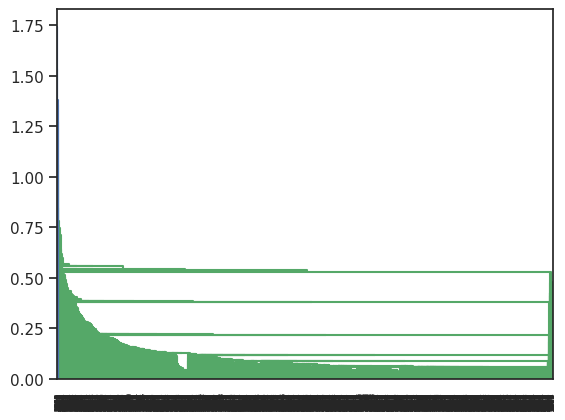

In [35]:
from scipy.cluster.hierarchy import linkage
from scipy.cluster.hierarchy import dendrogram
from scipy.cluster.hierarchy import cut_tree

# Single linkage:

mergings = linkage(rfm_df_scaled, method="single", metric='euclidean')
dendrogram(mergings)
plt.show()

**Complete Linkage**

In complete linkage hierarchical clustering, the distance between two clusters is defined as the longest distance between two points in each cluster. For example, the distance between clusters “r” and “s” to the left is equal to the length of the arrow between their two furthest points.

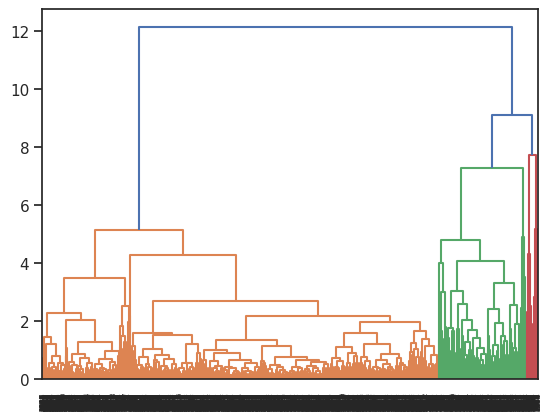

In [36]:
# Complete linkage

mergings = linkage(rfm_df_scaled, method="complete", metric='euclidean')
dendrogram(mergings)
plt.show()

**Average Linkage:**

In average linkage hierarchical clustering, the distance between two clusters is defined as the average distance between each point in one cluster to every point in the other cluster. For example, the distance between clusters “r” and “s” to the left is equal to the average length each arrow between connecting the points of one cluster to the other.

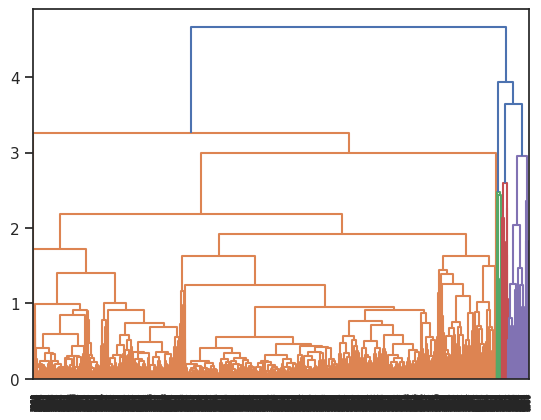

In [37]:
# Average linkage

mergings = linkage(rfm_df_scaled, method="average", metric='euclidean')
dendrogram(mergings)
plt.show()

In [38]:
# 3 clusters
cluster_labels = cut_tree(mergings, n_clusters=3).reshape(-1, )
cluster_labels

array([0, 0, 0, ..., 0, 0, 0])

In [39]:
# Assign cluster labels

merged_rfm['Cluster_Labels'] = cluster_labels
merged_rfm.head()

,Amount,Frequency,Recency,Cluster_Id,Cluster_2D,Cluster_3D,Cluster_Labels
CustomerID,,,,,,,
12346.0,0.00,2,326,1,0,0,0
12347.0,4310.00,182,3,0,2,2,0
12348.0,1797.24,31,76,2,2,2,0
12349.0,1757.55,73,19,2,2,2,0
12350.0,334.40,17,311,1,0,0,0


In [40]:
fig = px.box(merged_rfm, x='Cluster_Labels', y='Amount',
             title="Cluster Labels vs Amount Box Plot",
             labels={'Cluster_Labels': 'Cluster Labels', 'Amount': 'Amount'})

fig.update_layout(
    xaxis=dict(title="Cluster Labels", title_font=dict(size=14)),
    yaxis=dict(title="Amount", title_font=dict(size=14)),
    showlegend=False,
    width=800,
    height=600
)

fig.show()

In [41]:
fig = px.box(merged_rfm, x='Cluster_Labels', y='Frequency',
             title="Cluster Labels vs Frequency Box Plot",
             labels={'Cluster_Labels': 'Cluster Labels', 'Frequency': 'Frequency'})

fig.update_layout(
    xaxis=dict(title="Cluster Labels", title_font=dict(size=14)),
    yaxis=dict(title="Frequency", title_font=dict(size=14)),
    showlegend=False,
    width=800,
    height=600
)

fig.show()

In [42]:
fig = px.box(merged_rfm, x='Cluster_Labels', y='Recency',
             title="Cluster Labels vs Recency Box Plot",
             labels={'Cluster_Labels': 'Cluster Labels', 'Recency': 'Recency'})

fig.update_layout(
    xaxis=dict(title="Cluster Labels", title_font=dict(size=14)),
    yaxis=dict(title="Recency", title_font=dict(size=14)),
    showlegend=False,
    width=800,
    height=600
)

fig.show()

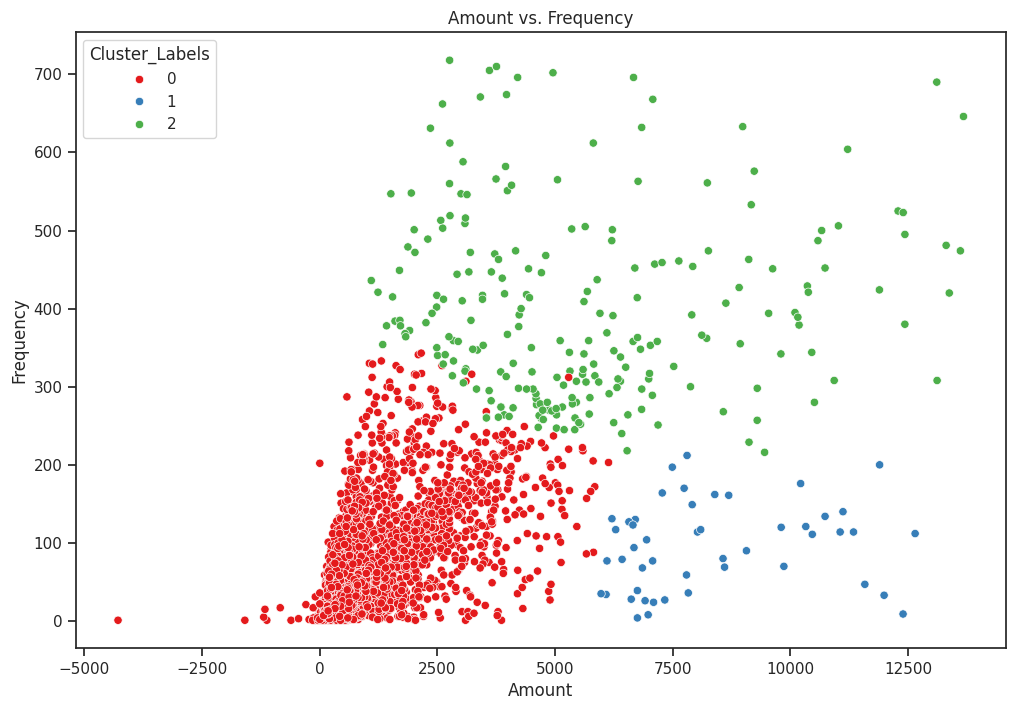

In [43]:
# Pairwise scatter plots for clustering (2D)
plt.figure(figsize=(12, 8))  # Adjust the figure size here

# Amount vs. Frequency
sns.scatterplot(x='Amount', y='Frequency', hue='Cluster_Labels', data=merged_rfm, palette='Set1')
plt.title('Amount vs. Frequency');

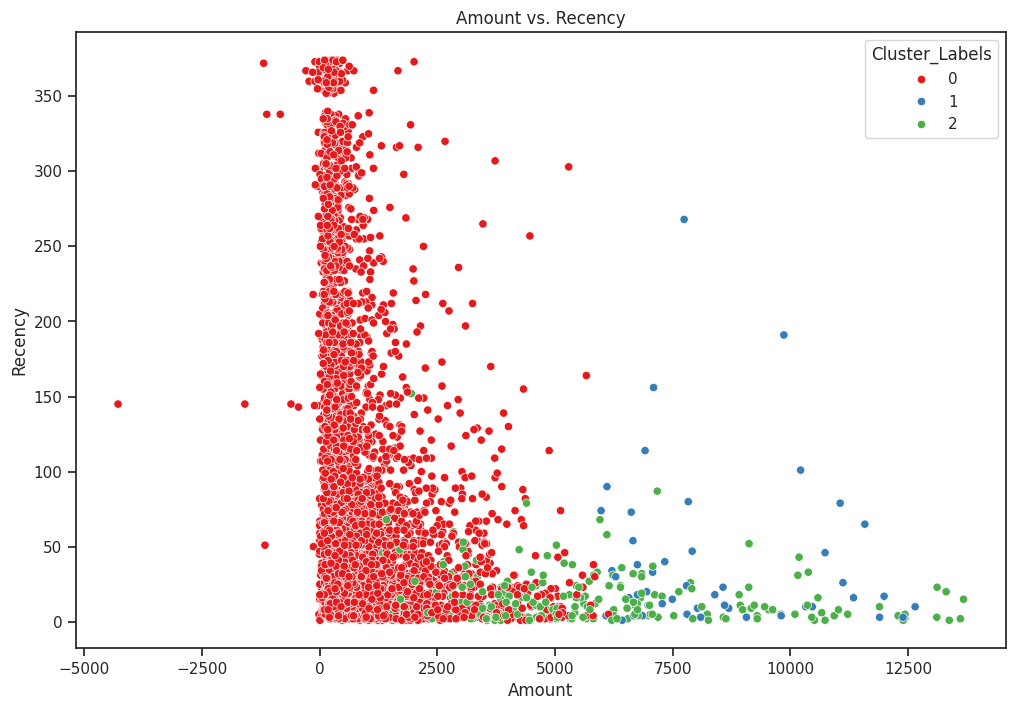

In [44]:
plt.figure(figsize=(12, 8))  # Adjust the figure size here

sns.scatterplot(x='Amount', y='Recency', hue='Cluster_Labels', data=merged_rfm, palette='Set1')
plt.title('Amount vs. Recency');

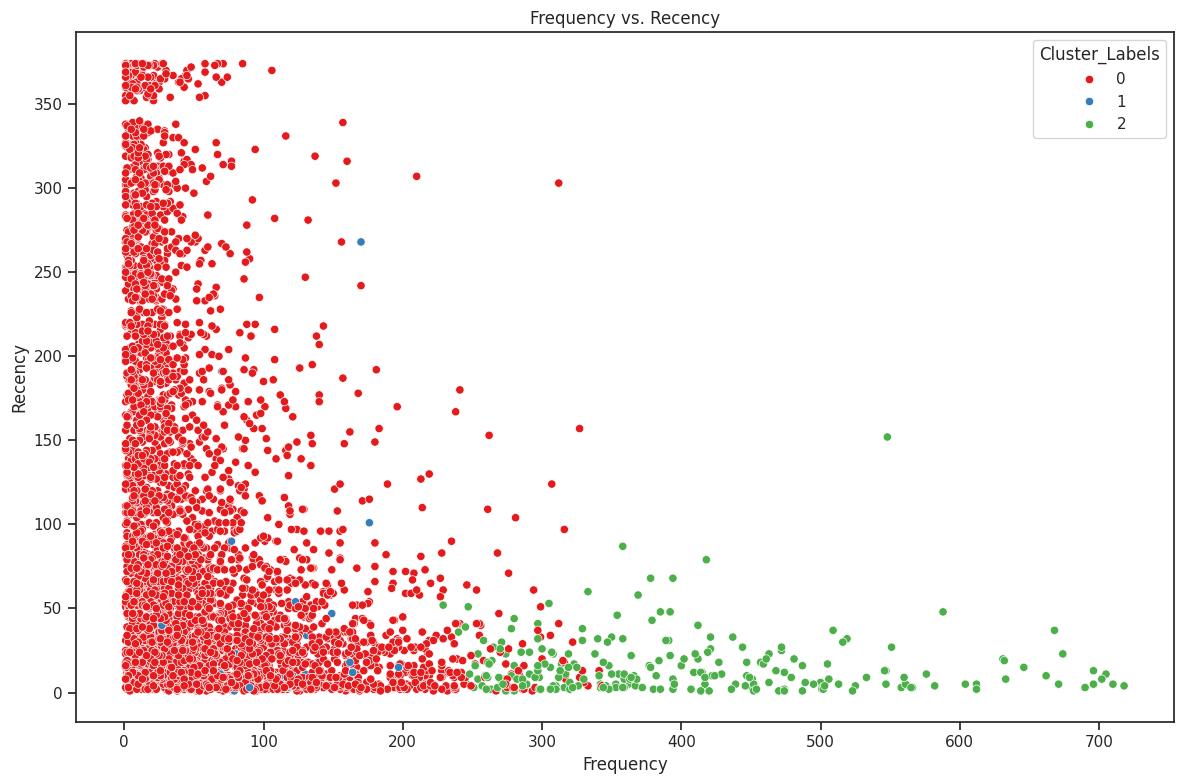

In [45]:
# Frequency vs. Recency
plt.figure(figsize=(12, 8))  # Adjust the figure size here
sns.scatterplot(x='Frequency', y='Recency', hue='Cluster_Labels', data=merged_rfm, palette='Set1')
plt.title('Frequency vs. Recency')

plt.tight_layout()
plt.show()

In [46]:
# Create a 3D scatter plot matrix with Plotly
fig = px.scatter_3d(merged_rfm, x='Amount', y='Frequency', z='Recency', color='Cluster_Labels',
                     labels={'Amount': 'Amount', 'Frequency': 'Frequency', 'Recency': 'Recency', 'Cluster_3D': 'Cluster'})

fig.update_layout(
    scene=dict(
        xaxis_title='Amount',
        yaxis_title='Frequency',
        zaxis_title='Recency',
    ),
    title='Clustering by Amount, Frequency, and Recency',
    width=800,
    height=600
)

fig.show()

In [47]:
import plotly.express as px

# Apply K-Means clustering
kmeans = KMeans(n_clusters=n_clusters)
merged_rfm['Cluster_3D'] = kmeans.fit_predict(data_for_clustering)

# Create a 3D scatter plot matrix with Plotly
fig = px.scatter_3d(merged_rfm, x='Amount', y='Frequency', z='Recency', color='Cluster_3D',
                     labels={'Amount': 'Amount', 'Frequency': 'Frequency', 'Recency': 'Recency', 'Cluster_3D': 'Cluster'})

fig.update_layout(
    scene=dict(
        xaxis_title='Amount',
        yaxis_title='Frequency',
        zaxis_title='Recency',
    ),
    title='Clustering by Amount, Frequency, and Recency',
    width=800,
    height=600
)

fig.show()

## **Analytical results**

**Inference**:

**K-Means Clustering with 3 Cluster Ids**\
 By using the plot, we know how each segment differs. It describes more than we use the summarized table. We infer that cluster 1 is frequent, spend more, and they buy the product recently. Therefore, it could be the cluster of a loyal customer. Then, the cluster 2 is less frequent, less to spend, but they buy the product recently. Therefore, it could be the cluster of new customer. Finally, the cluster 0 is less frequent, less to spend, and they buy the product at the old time. Therefore, it could be the cluster of churned customers.

**Hierarchical Clustering with 3 Cluster Ids**

According to the plots of hierarchical clustering we can infer that customers in cluster 2 are frequent buyers and buy high amount. Cluster 1 customers are also high amount buyers but buy
less frequent than the customers in cluster 1. Cluster 0 customers are the one who buy least amount and frequency is also lower than cluster 1 and cluster 2.

## **Conclusions**

Here are some of the key outcomes of the project:

- Did **Data exploration**.
- Data Cleaning (Dropping **Missing Values** and **removing outliers**).
- (**EDA**) Visualising the distribution of data & their relationships, helped us to get some insights on the relationship between the feature-set.
- Appropriate Transformations were applied on the data to satisfy the key assumptions. Followed by **Standardization**.
- **K Means** algorithm was applied and ***k parameter is tuned*** using the ***Elbow Plot*** and ***Silhouette***.Results are plotted.
- **Hierarchical Clustering** is applied and results are also plotted.

Made Inference on the customers of resulting clusters based on the clustering result of these models.
